# Reinforcement Learning

# 3. Online evaluation

This notebook presents the online evaluation of a policy by **Monte-Carlo learning** and **TD learning**.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from tqdm.notebook import tqdm

from utils.model import Maze, Walk, TicTacToe, Nim, ConnectFour
from utils.agent import Agent, OnlineEvaluation
from utils.dynamic import PolicyEvaluation

%matplotlib inline

In [2]:
from IPython.core.display import display, HTML

def display_answer(title, answer):
    if isinstance(answer, list):
        string_display = f"""<div class="alert alert-block alert-success"> <h1>{title}:</h1><ul>"""
        for a in answer:
            string_display += f"<li>{a}</li>"
        string_display += "</ul></div>"
    elif isinstance(answer, str):
        string_display = f"""<div class="alert alert-block alert-success"> <h1>{title}:</h1>{answer} </div>"""
    else:
        raise ValueError("Answer should be a string or a list of strings.")
    display(HTML(string_display))

## To do

* Complete the class ``MCLearning`` and test it on the random walk.
* Compare with the exact solution obtained by Dynamic Programming.<br> You might plot the [Spearman's correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) between both value functions with respect to the training time.
* Do the same with ``TDLearning``.

## Monte-Carlo learning

In [3]:
class MCLearning(OnlineEvaluation):
    """Online evaluation by Monte-Carlo."""
        
    def update_values(self, state=None, horizon=100):
        """Update the values from one episode."""
        stop, states, rewards = self.get_episode(state=state, horizon=horizon)
        # remove last state
        states.pop()
        gain = 0
        # backward update
        for state, reward in zip(reversed(states), reversed(rewards)):
            self.add_state(state)
            code = self.model.encode(state)
            self.count[code] += 1
            # to be modified
            # begin
            gain = reward + self.gamma * gain
            # end 
            diff = gain - self.value[code]
            count = self.count[code]
            self.value[code] += diff / count


## TD learning

In [4]:
class TDLearning(OnlineEvaluation):
    """Online evaluation by TD learning."""
        
    def update_values(self, state=None, horizon=100):
        """Update values online from one episode."""
        self.model.reset(state)
        for t in range(horizon):
            state = self.model.state
            code = self.model.encode(state)
            self.add_state(state)
            action = self.get_action(state)
            reward, stop = self.model.step(action)
            next_state = self.model.state
            next_code = self.model.encode(next_state)
            self.add_state(next_state)
            gain = reward + self.gamma * self.value[next_code]
            diff = gain - self.value[code]
            self.count[code] += 1  # Increment count
            self.value[code] += diff / self.count[code]  # Update value
            if stop:
                break


## Walk

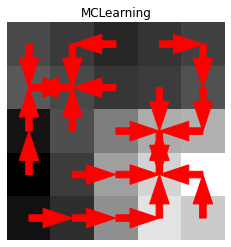

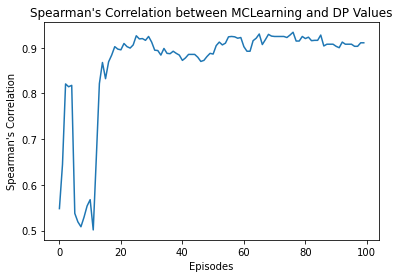

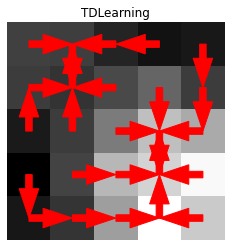

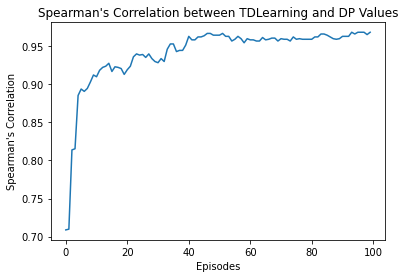

In [5]:
for algo in [MCLearning, TDLearning]:
    walk = Walk()
    algo = algo(walk, policy='random', gamma=0.9)
    n_episodes = 100
    algo_values_list = []

    for t in range(n_episodes):
        algo.update_values()
        algo_values_list.append(algo.get_values().copy())
    policy = algo.get_policy()
    walk.display_policy(policy)
    values = algo.get_values()
    walk.display_values(values)
    plt.title(algo.__class__.__name__)
    plt.show()

    # Comparison with dynamic programming
    dynamic = PolicyEvaluation(walk, policy='random', gamma=0.9)
    dynamic.evaluate_policy()
    dp_values = dynamic.values

    # Calculate Spearman's correlation
    spearman_correlations = [spearmanr(algo_values, dp_values).correlation for algo_values in algo_values_list]

    # Plot Spearman's correlation
    plt.plot(range(n_episodes), spearman_correlations)
    plt.xlabel('Episodes')
    plt.ylabel('Spearman\'s Correlation')
    plt.title(f'Spearman\'s Correlation between {algo.__class__.__name__} and DP Values')
    plt.show()
answer = "The values obtained by Monte-Carlo learning and TD learning converge to the values obtained by Dynamic Programming. For TD learning though, it converges faster than for Monte-Carlo learning."
display_answer("Results", answer)

## To do

Test the other environments:
* The maze: can you find the exit after policy improvement?<br> You might adapt the number of episodes used for training.
* The games (Tic-Tac-Toe, Nim, Connect Four): can you beat a random player after policy improvement? a player with the one-step policy?<br> Comment the results.

## Maze

Training MCLearning to find the exit:   0%|          | 0/2000 [00:00<?, ?it/s]

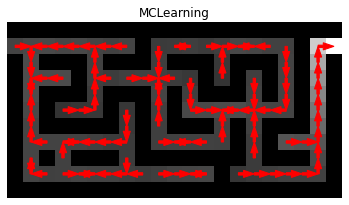

In [6]:
maze_map = np.load('utils/maze.npy')
init_state = (1, 0)
exit_state = (1, 20)
Maze.set_parameters(maze_map, init_state, [exit_state])
maze = Maze()
algo = MCLearning(maze, policy='random')
n_episodes = 2000
for t in tqdm(range(n_episodes), desc=f'Training {algo.__class__.__name__} to find the exit'):
    algo.update_values(state='random')
policy = algo.get_policy()
maze.display_policy(policy)
values = algo.get_values()
maze.display_values(values)
plt.title(algo.__class__.__name__)
plt.show()
answer = "The agent struggles to find the exit, even after 2000 episodes. This is because the agent is not able to explore the maze efficiently with a random policy."
display_answer("Results", answer)

## Games

### Tic-Tac-Toe

Training MCLearning to beat the random player at TicTacToe:   0%|          | 0/100 [00:00<?, ?it/s]

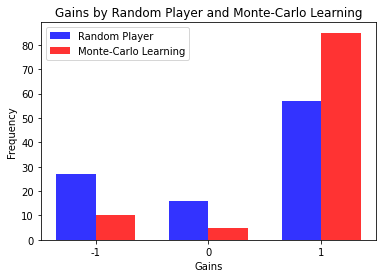

In [7]:
Game = TicTacToe
# random player
game = Game()
agent = Agent(game)
gains_random=np.unique(agent.get_gains(), return_counts=True)

# Monte-Carlo learning
game = Game()
algo = MCLearning(game, policy='random')
n_episodes = 100
for t in tqdm(range(n_episodes), desc=f'Training {algo.__class__.__name__} to beat the random player at {game.__class__.__name__}'):
    algo.update_values(state='random')
# evaluate policy against random player
agent = Agent(game, policy=algo.get_policy())
gains_mc_learning = np.unique(agent.get_gains(), return_counts=True)

# Show plot results in barchart for random player and Monte-Carlo
fig, ax = plt.subplots()
bar_width = 0.35
index = np.array([-1., 0., 1.])
opacity = 0.8
rects1 = plt.bar(index - bar_width/2, gains_random[1], bar_width, alpha=opacity, color='b', label='Random Player')
rects2 = plt.bar(index + bar_width/2, gains_mc_learning[1], bar_width, alpha=opacity, color='r', label='Monte-Carlo Learning')
plt.xlabel('Gains')
plt.ylabel('Frequency')
plt.xticks(index, gains_random[0])
plt.title('Gains by Random Player and Monte-Carlo Learning')
plt.legend()
plt.show()
answer = "The Monte-Carlo learning agent is able to beat the random player more often than the random player itself."
display_answer('Results', answer)

### Nim

Training MCLearning to beat the random player at Nim:   0%|          | 0/1000 [00:00<?, ?it/s]

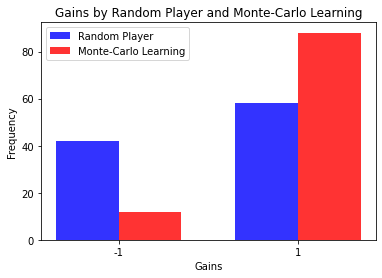

In [8]:
Game = Nim
# random player
game = Game()
agent = Agent(game)
gains_random=np.unique(agent.get_gains(), return_counts=True)
# Monte-Carlo learning
game = Game()
algo = MCLearning(game, policy='random')
n_episodes = 1000
for t in tqdm(range(n_episodes), desc=f'Training {algo.__class__.__name__} to beat the random player at {game.__class__.__name__}'):
    algo.update_values(state='random')
# evaluate policy against random player
agent = Agent(game, policy=algo.get_policy())
gains_mc_learning = np.unique(agent.get_gains(), return_counts=True)

# Show plot results in barchart for random player and Monte-Carlo
fig, ax = plt.subplots()
bar_width = 0.35
index = np.array([0., 1.])
opacity = 0.8
rects1 = plt.bar(index - bar_width/2, gains_random[1], bar_width, alpha=opacity, color='b', label='Random Player')
rects2 = plt.bar(index + bar_width/2, gains_mc_learning[1], bar_width, alpha=opacity, color='r', label='Monte-Carlo Learning')
plt.xlabel('Gains')
plt.ylabel('Frequency')
plt.xticks(index, gains_random[0])
plt.title('Gains by Random Player and Monte-Carlo Learning')
plt.legend()
plt.show()
answer = "The Monte-Carlo learning agent is able to beat the random player more often than the random player itself."
display_answer("Results", answer)

### Connect Four

Training MCLearning to beat the  player at ConnectFour:   0%|          | 0/1000 [00:00<?, ?it/s]

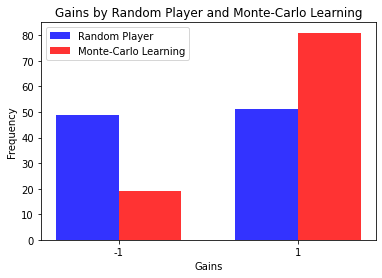

In [9]:
Game = ConnectFour
# random player
game = Game()
agent = Agent(game)
gains_random=np.unique(agent.get_gains(), return_counts=True)
# Monte-Carlo learning
game = Game()
algo = MCLearning(game, policy='one_step')
n_episodes = 1000
for t in tqdm(range(n_episodes), desc=f'Training {algo.__class__.__name__} to beat the  player at {game.__class__.__name__}'):
    algo.update_values()
# evaluate policy against random player
agent = Agent(game, policy=algo.get_policy())
gains_mc_learning = np.unique(agent.get_gains(), return_counts=True)

# Show plot results in barchart for random player and Monte-Carlo
fig, ax = plt.subplots()
bar_width = 0.35
index = np.array([0., 1.])
opacity = 0.8
rects1 = plt.bar(index - bar_width/2, gains_random[1], bar_width, alpha=opacity, color='b', label='Random Player')
rects2 = plt.bar(index + bar_width/2, gains_mc_learning[1], bar_width, alpha=opacity, color='r', label='Monte-Carlo Learning')
plt.xlabel('Gains')
plt.ylabel('Frequency')
plt.xticks(index, gains_random[0])
plt.title('Gains by Random Player and Monte-Carlo Learning')
plt.legend()
plt.show()
answer = "The Monte-Carlo learning agent is able to beat the random player more often than the random player itself."
display_answer("Results", answer)